In [1]:
# !pip install tensorflow-text
# import tensorflow_text

# Kütüphaneler

In [1]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.rcParams['figure.figsize'] = (12, 8)

print("Version: ", tf.__version__)

Version:  2.11.0


# Veri Yüklenmesi

In [2]:
url = "https://archive.org/download/fine-tune-bert-tensorflow-train.csv/train.csv.zip"

dataframe = pd.read_csv(url, compression='zip')
dataframe.shape

(1306122, 3)

In [3]:
dataframe.head(2)

,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0


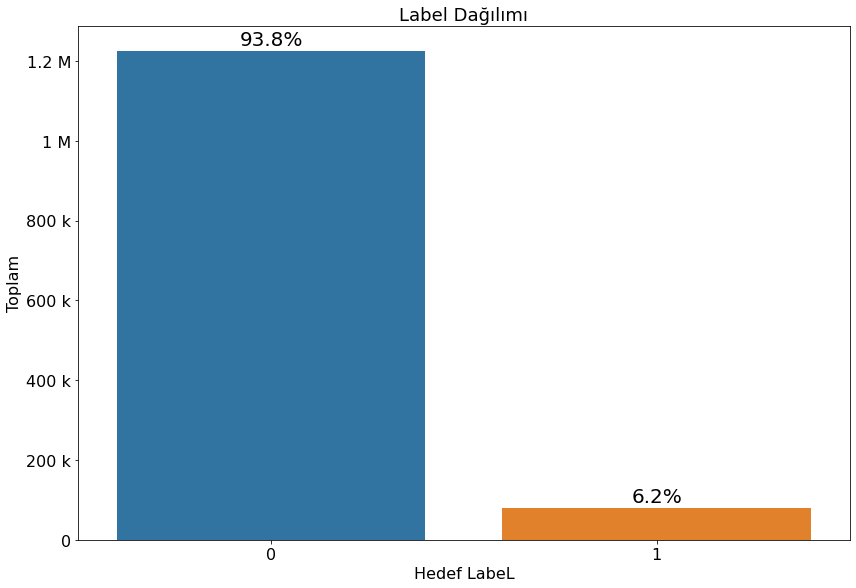

In [4]:
ax = sns.countplot(data = dataframe, x = 'target')
plt.xticks(size=16)
plt.xlabel('Hedef LabeL', size = 16)
plt.yticks(size=16)
plt.ylabel('Toplam', size=16)
ax.yaxis.set_major_formatter(ticker.EngFormatter())

ax.set_xticklabels(ax.get_xticklabels(), ha="center")
total = len(dataframe)
for p in ax.patches:
    percentage = f'{100 * p.get_height() / total:.1f}%\n'
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(percentage, (x, y), ha='center', va='center', fontsize=20)
plt.tight_layout()
plt.title('Label Dağılımı', fontsize = 18)
plt.show()

# TF.Data Pipeline

In [5]:
features, labels = dataframe["question_text"], dataframe["target"]

In [6]:
train_features, X_test, train_labels, y_test = train_test_split(
                                                            features, 
                                                            labels,
                                                            train_size = 0.8,
                                                            stratify=labels,
                                                            random_state=1002
)

In [12]:
train_features.shape, train_labels.shape

((1044897,), (1044897,))

In [13]:
X_train, X_val, y_train, y_val = train_test_split(
                                    train_features, train_labels,
                                    train_size = 0.8,
                                    stratify=train_labels,
                                    random_state=1002
)

In [14]:
X_train.shape, y_train.shape

((835917,), (835917,))

In [15]:
y_train[:2]

10557     0
862949    0
Name: target, dtype: int64

In [32]:
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val))
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))

In [33]:
next(iter(train_ds))

(<tf.Tensor: shape=(), dtype=string, numpy=b'What month will my hair grow back if I cut it back on February 25?'>,
 <tf.Tensor: shape=(), dtype=int64, numpy=0>)

In [34]:
408*2048 - 835917

-333

In [35]:
train_ds = train_ds.shuffle(4096).batch(2048, drop_remainder=False).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.batch(2048).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.batch(2048).prefetch(tf.data.AUTOTUNE)

In [36]:
train_ds

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

# Modeli Oluştur

In [37]:
embedding_link = "https://tfhub.dev/google/tf2-preview/nnlm-en-dim128/1"

embedding = hub.KerasLayer(
    embedding_link
    )

In [47]:
sample = tf.constant(["hi guys bro", "hello darkness my old friend"])
sample

<tf.Tensor: shape=(2,), dtype=string, numpy=array([b'hi guys bro', b'hello darkness my old friend'], dtype=object)>

In [ ]:
embedding(sample)

In [58]:
input_layer = tf.keras.Input(batch_input_shape = (None, ), dtype = tf.string)
embedding_output = embedding(input_layer)

# 1.branch
x = tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1))(embedding_output)
x = tf.keras.layers.Conv1D(filters=16, kernel_size = 5)(x)
x = tf.nn.silu(x)
x = tf.keras.layers.AveragePooling1D()(x)
x = tf.keras.layers.Conv1D(filters=32, kernel_size = 5)(x)
x = tf.nn.silu(x)
x = tf.keras.layers.GlobalAveragePooling1D()(x)

#2. branch
y = tf.keras.layers.Dense(128)(embedding_output)
y = tf.nn.silu(y)

merged = tf.keras.layers.Concatenate()([x, y])

final_layer = tf.keras.layers.Dense(1)(merged)
final_layer = tf.nn.sigmoid(final_layer)

model_normal = tf.keras.Model(input_layer, final_layer)

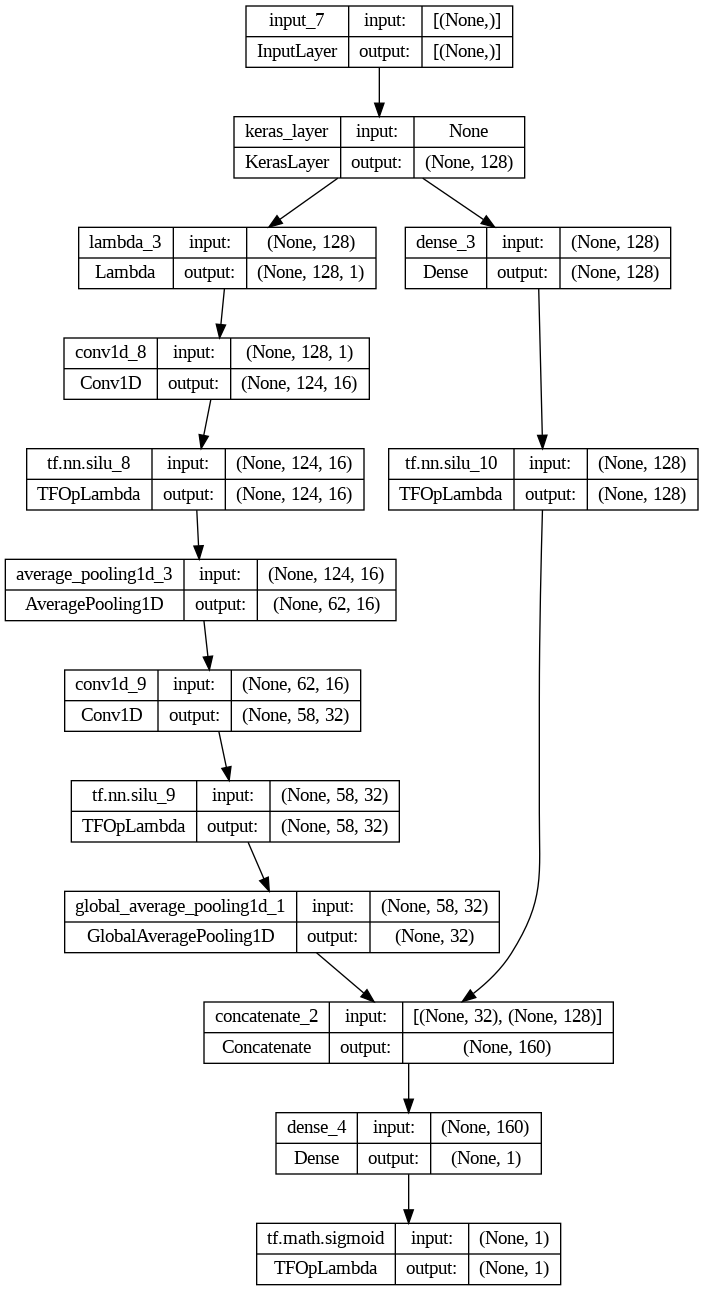

In [59]:
tf.keras.utils.plot_model(model_normal, show_shapes=True)

In [76]:
model_normal.layers[1].trainable = True

In [77]:
model_normal.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       (None, 128)          124642688   ['input_7[0][0]']                
                                                                                                  
 lambda_3 (Lambda)              (None, 128, 1)       0           ['keras_layer[5][0]']            
                                                                                                  
 conv1d_8 (Conv1D)              (None, 124, 16)      96          ['lambda_3[0][0]']               
                                                                                            

In [ ]:
model_focal = tf.keras.models.clone_model(model_normal)

In [73]:
model_normal.save_weights("starting_point.h5")

In [78]:
model_normal.compile(optimizer = "adam",
                     loss = tf.keras.losses.BinaryCrossentropy(),
                     metrics = [tf.keras.metrics.TruePositives(),
                                tf.keras.metrics.FalseNegatives()])

In [79]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    min_lr = 1e-8, verbose=1, patience=3
)

model_normal.fit(train_ds, validation_data=val_ds, epochs = 32, callbacks = [reduce_lr])

Epoch 1/32
409/409 [==============================] - 57s 118ms/step - loss: 0.1625 - true_positives: 15314.0000 - false_negatives: 36404.0000 - val_loss: 0.1266 - val_true_positives: 5416.0000 - val_false_negatives: 7514.0000 - lr: 0.0010
Epoch 2/32
409/409 [==============================] - 19s 47ms/step - loss: 0.1151 - true_positives: 24245.0000 - false_negatives: 27473.0000 - val_loss: 0.1247 - val_true_positives: 5892.0000 - val_false_negatives: 7038.0000 - lr: 0.0010
Epoch 3/32
409/409 [==============================] - 13s 31ms/step - loss: 0.1062 - true_positives: 27089.0000 - false_negatives: 24629.0000 - val_loss: 0.1277 - val_true_positives: 6320.0000 - val_false_negatives: 6610.0000 - lr: 0.0010
Epoch 4/32
409/409 [==============================] - 10s 25ms/step - loss: 0.0991 - true_positives: 29034.0000 - false_negatives: 22684.0000 - val_loss: 0.1333 - val_true_positives: 6191.0000 - val_false_negatives: 6739.0000 - lr: 0.0010
Epoch 5/32
409/409 [=======================

In [80]:
from sklearn.metrics import classification_report, confusion_matrix

In [88]:
def evaluate_model(model,
                   threshold,
                   dataset):
    predictions = []
    true_labels = []

    for x, y in dataset:
        predictions.append(model(x).numpy())
        true_labels.append(y.numpy())

    predictions = np.concatenate(predictions, axis = 0)
    true_labels = np.concatenate(true_labels, axis = 0)

    predictions = np.where(predictions > threshold, 1, 0)

    print(classification_report(true_labels, predictions, digits = 4))

    plt.figure(figsize = (12, 8))
    sns.heatmap(confusion_matrix(true_labels, predictions),
                annot=True, fmt = ".4f")
    plt.show()

              precision    recall  f1-score   support

           0     0.9761    0.9641    0.9701    245063
           1     0.5414    0.6422    0.5876     16162

    accuracy                         0.9442    261225
   macro avg     0.7588    0.8032    0.7788    261225
weighted avg     0.9492    0.9442    0.9464    261225



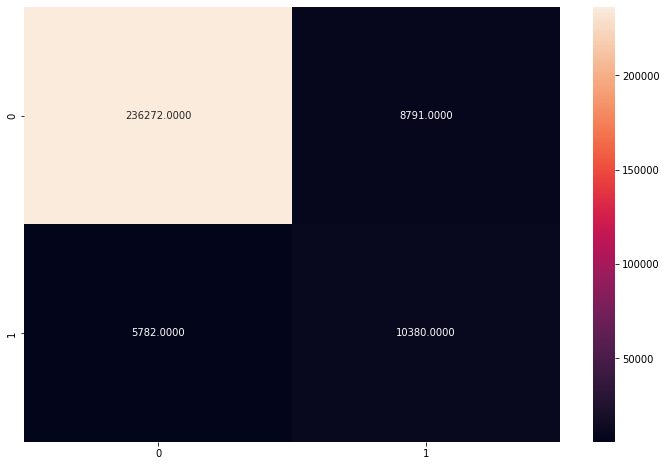

In [90]:
evaluate_model(model = model_normal, 
               threshold = 0.3,
               dataset = test_ds)

## 2.Model

In [92]:
model_focal.load_weights("/content/starting_point.h5")

In [93]:
model_focal.compile(optimizer = "adam",
                     loss = tf.keras.losses.BinaryFocalCrossentropy(),
                     metrics = [tf.keras.metrics.TruePositives(),
                                tf.keras.metrics.FalseNegatives()])

In [94]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    min_lr = 1e-8, verbose=1, patience=3
)

model_focal.fit(train_ds, validation_data=val_ds, epochs = 32, callbacks = [reduce_lr])

Epoch 1/32
409/409 [==============================] - 6s 11ms/step - loss: 0.0478 - true_positives_1: 9373.0000 - false_negatives_1: 42345.0000 - val_loss: 0.0407 - val_true_positives_1: 3505.0000 - val_false_negatives_1: 9425.0000 - lr: 0.0010
Epoch 2/32
409/409 [==============================] - 4s 10ms/step - loss: 0.0404 - true_positives_1: 14076.0000 - false_negatives_1: 37642.0000 - val_loss: 0.0403 - val_true_positives_1: 3450.0000 - val_false_negatives_1: 9480.0000 - lr: 0.0010
Epoch 3/32
409/409 [==============================] - 4s 10ms/step - loss: 0.0400 - true_positives_1: 14313.0000 - false_negatives_1: 37405.0000 - val_loss: 0.0400 - val_true_positives_1: 3596.0000 - val_false_negatives_1: 9334.0000 - lr: 0.0010
Epoch 4/32
409/409 [==============================] - 4s 10ms/step - loss: 0.0397 - true_positives_1: 14523.0000 - false_negatives_1: 37195.0000 - val_loss: 0.0398 - val_true_positives_1: 3786.0000 - val_false_negatives_1: 9144.0000 - lr: 0.0010
Epoch 5/32
409/40

              precision    recall  f1-score   support

           0     0.9864    0.8873    0.9342    245063
           1     0.3227    0.8143    0.4623     16162

    accuracy                         0.8828    261225
   macro avg     0.6546    0.8508    0.6983    261225
weighted avg     0.9453    0.8828    0.9050    261225



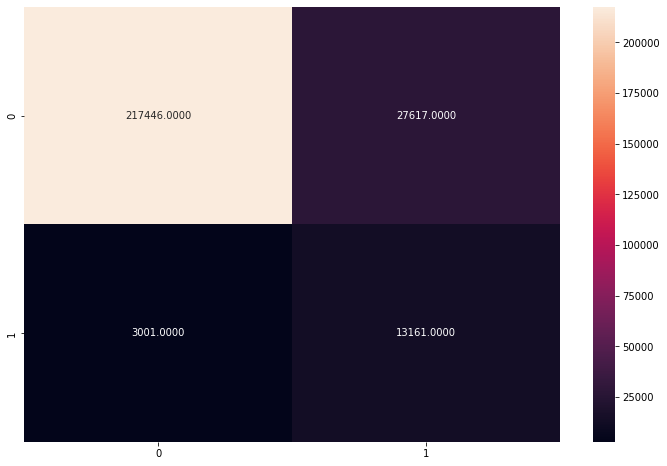

In [98]:
evaluate_model(model = model_focal, 
               threshold = 0.3,
               dataset = test_ds)

## Loss Karşılaştırması

In [109]:
bce_loss = tf.keras.losses.BinaryCrossentropy(reduction="none")
bfce_loss = tf.keras.losses.BinaryFocalCrossentropy(reduction="none")

In [110]:
predictions = np.array([[0.1], [0.9], [0.2], [0.3]])
labels = np.array([[0.0], [1.0], [1.0], [0.0]])

In [111]:
bce_loss(predictions, labels)

<tf.Tensor: shape=(4,), dtype=float64, numpy=array([ 1.54249485,  1.54249485, 12.33995878,  4.62748454])>

In [112]:
bfce_loss(predictions, labels)

<tf.Tensor: shape=(4,), dtype=float64, numpy=array([0.01542495, 0.01542495, 7.89757362, 0.41647361])>